In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, RobustScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import length, col, expr
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 200)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 21:06:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/06 21:06:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/06 21:06:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [7]:
data = spark.read.option('escape','"').csv('kickstarter_cleaned.csv', header=True, inferSchema=True, mode="DROPMALFORMED")
data = data.dropna()

In [8]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

## Pipeline
- String Indexer on categorical columns
- Label indexer on "state" target column
- Vector Assembler on numerical columns -> Robust Scaler
- Vector Assembler on scaled features + categorical features

In [9]:
categorical_cols = ["main_category", "currency", "year", "month", "day_of_week", "continent", "use_of_?!"]
numerical_cols = ["goal", "time_interval", "length_of_title"]

In [10]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

label_indexer = StringIndexer(inputCol="state", outputCol="state_index")

In [11]:
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
scaler = RobustScaler(inputCol="features", outputCol="scaled_features")

In [12]:
assembler_all = VectorAssembler(inputCols=["scaled_features"] + [col+"_index" for col in categorical_cols], outputCol="final_features")

In [13]:
pipeline = Pipeline(stages=indexers + [label_indexer, num_assembler, scaler, assembler_all])
pipeline_model = pipeline.fit(trainingData)
trainingData = pipeline_model.transform(trainingData)

## GBT Model

The model defined here use the hyperparameters found with the grid search. Useful to test the model and avoid a huge computation time do to the cross validation.

In [14]:
gbt = GBTClassifier(featuresCol="final_features", labelCol="state_index", maxDepth=5, maxIter=30, stepSize=0.2)
gbt_model = gbt.fit(trainingData)

In [15]:
evaluator_ROC = BinaryClassificationEvaluator(labelCol="state_index", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="state_index", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="state_index", metricName="f1")

In [16]:
testData = pipeline_model.transform(testData)

In [17]:
predictions = gbt_model.transform(testData)

area_under_roc = evaluator_ROC.evaluate(predictions)
print(f"Area under ROC on test data = {area_under_roc}")

accuracy = evaluator_acc.evaluate(predictions)
print(f"Accuracy on test data = {accuracy}")

f1 = evaluator_f1.evaluate(predictions)
print(f"Accuracy on test data = {f1}")

Area under ROC on test data = 0.7271306362921649


Accuracy on test data = 0.6763290834736589


Accuracy on test data = 0.6693893770306584


### With Cross Validation + GridSearch

In [11]:
gbt = GBTClassifier(featuresCol="final_features", labelCol="state_index")

param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .build()

In [12]:
evaluator = BinaryClassificationEvaluator(labelCol="state_index", metricName="areaUnderROC")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=4) 

In [13]:
%%time
cv_model = crossval.fit(trainingData)

23/11/30 14:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
23/11/30 14:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1028.7 KiB
23/11/30 14:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1037.1 KiB
23/11/30 14:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
23/11/30 14:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB
23/11/30 14:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1039.7 KiB
23/11/30 14:37:39 WAR

CPU times: user 3.82 s, sys: 791 ms, total: 4.61 s
Wall time: 24min 1s


In [14]:
testData = pipeline_model.transform(testData)
predictions = cv_model.transform(testData)

area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on test data = {area_under_roc}")

best_model = cv_model.bestModel

print("Best hyperparameters:")
print(f"Max Depth: {best_model.getMaxDepth()}")
print(f"Max Iterations: {best_model.getMaxIter()}")
print(f"stepSize: {best_model.getStepSize()}")

Area under ROC on test data = 0.732024668159765
Best hyperparameters:
Max Depth: 5
Max Iterations: 30
stepSize: 0.2


## Feature Importance

In [18]:
#best_model = gbt_model
#Collect feature importance scores
feature_importance = best_model.featureImportances
feature_importance_scores = feature_importance.toArray().tolist()

#Rename the numerical columns
original_numerical_features = ["goal", "time_interval", "length_of_title"]
original_numerical_indices = [num_assembler.getInputCols().index(feature) for feature in original_numerical_features]

#Mapping original numerical feature names to importance scores
original_numerical_importance_dict = dict(zip(original_numerical_features, [feature_importance_scores[i] for i in original_numerical_indices]))


#Rename the categorical columns (e.g. year_index -> year)
original_categorical_features = ["main_category", "currency", "year", "month", "day_of_week", "continent", "use_of_?!"]
original_categorical_indices = [assembler_all.getInputCols().index(feature + "_index") for feature in original_categorical_features]

#Mmapping original categorical feature names to importance scores
original_categorical_importance_dict = dict(zip(original_categorical_features, [feature_importance_scores[i] for i in original_categorical_indices]))

#Print numerical feature importance scores
print("Numerical Feature Importance Scores:")
for feature, importance in sorted(original_numerical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

#Print categorical feature importance scores
print("\nCategorical Feature Importance Scores:")
for feature, importance in sorted(original_categorical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Numerical Feature Importance Scores:
time_interval: 0.2231500236139206
goal: 0.1969243487678999
length_of_title: 0.08286304217342445

Categorical Feature Importance Scores:
year: 0.23395633963753695
main_category: 0.2231500236139206
day_of_week: 0.1173976361071017
currency: 0.08286304217342445
month: 0.05540096747019538
continent: 0.05384942252759639
use_of_?!: 0.029509205846789937


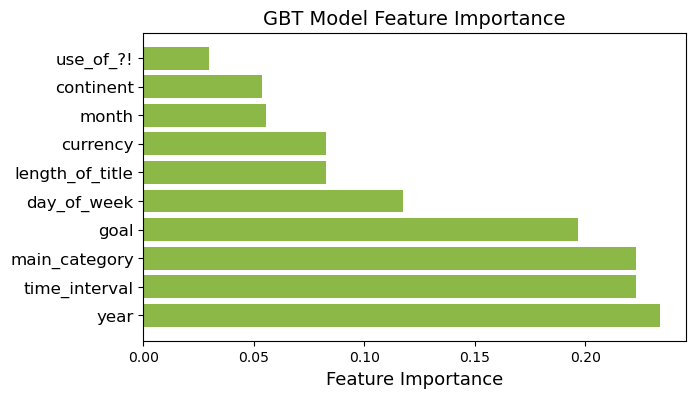

In [21]:
import matplotlib.pyplot as plt

#Combine numerical and categorical importance
all_importance_dict = {**original_numerical_importance_dict, **original_categorical_importance_dict}

#Sort features by importance
sorted_features = sorted(all_importance_dict.items(), key=lambda x: x[1], reverse=True)

#Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_features)

plt.figure(figsize=(7, 4))
plt.barh(range(len(features)), importance_scores, align='center', color='#8cb847')
plt.yticks(range(len(features)), features, fontsize=12)
plt.xlabel('Feature Importance', fontsize=13)
plt.title('GBT Model Feature Importance', fontsize=14)
plt.show()

### Removing Currency and adding the sub-category

In [22]:
categorical_cols = ["category", "main_category", "year", "month", "day_of_week", "continent", "use_of_?!"]
numerical_cols = ["goal", "time_interval", "length_of_title"]

#### Pipeline

In [23]:
#Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

#Index target label
label_indexer = StringIndexer(inputCol="state", outputCol="state_index")

#Scaling numerical columns
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
scaler = RobustScaler(inputCol="features", outputCol="scaled_features")

#Assembling all features
assembler_all = VectorAssembler(inputCols=["scaled_features"] + [col+"_index" for col in categorical_cols], outputCol="final_features")

In [24]:
pipeline = Pipeline(stages=indexers + [label_indexer, num_assembler, scaler, assembler_all])
pipeline_model = pipeline.fit(trainingData)
trainingData = pipeline_model.transform(trainingData)

IllegalArgumentException: requirement failed: Output column main_category_index already exists.

#### GBT Model

In [25]:
gbt = GBTClassifier(featuresCol="final_features", labelCol="state_index", \
                    maxDepth=5, \
                    maxIter=30, \
                    stepSize=0.2, \
                    maxBins=160)

gbt_model = gbt.fit(trainingData)

In [26]:
evaluator = BinaryClassificationEvaluator(labelCol="state_index", metricName="areaUnderROC")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="state_index", metricName="f1")

In [27]:
testData = pipeline_model.transform(testData)
predictions = gbt_model.transform(testData)

f1 = evaluator_f1.evaluate(predictions)
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on test data = {area_under_roc}")
print(f"F1 measure on test data = {f1}")

IllegalArgumentException: requirement failed: Output column main_category_index already exists.

#### Feature Importance

In [28]:
#Collect feature importance scores
feature_importance = gbt_model.featureImportances
feature_importance_scores = feature_importance.toArray().tolist()

#Rename the numerical columns
original_numerical_indices = [num_assembler.getInputCols().index(feature) for feature in numerical_cols]

#Mapping original numerical feature names to importance scores
original_numerical_importance_dict = dict(zip(numerical_cols, [feature_importance_scores[i] for i in original_numerical_indices]))

#Rename the categorical columns (e.g. year_index -> year)
original_categorical_indices = [assembler_all.getInputCols().index(feature + "_index") for feature in categorical_cols]

#Mmapping original categorical feature names to importance scores
original_categorical_importance_dict = dict(zip(categorical_cols, [feature_importance_scores[i] for i in original_categorical_indices]))

#Print numerical feature importance scores
print("Numerical Feature Importance Scores:")
for feature, importance in sorted(original_numerical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

#Print categorical feature importance scores
print("\nCategorical Feature Importance Scores:")
for feature, importance in sorted(original_categorical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Numerical Feature Importance Scores:
time_interval: 0.22010224962570932
goal: 0.19888371620122053
length_of_title: 0.08503347005558279

Categorical Feature Importance Scores:
year: 0.23111972170797498
category: 0.22010224962570932
day_of_week: 0.12199332076805919
main_category: 0.08503347005558279
continent: 0.05835562065912695
month: 0.04717827568035861
use_of_?!: 0.030300512379722342
currency: 0.0010114638010373575


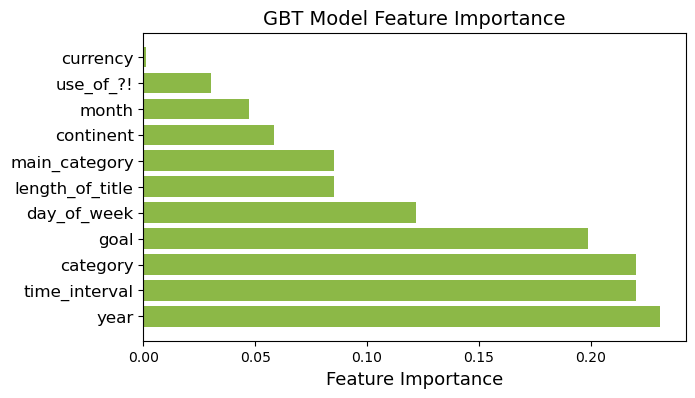

In [29]:
import matplotlib.pyplot as plt

#Combine numerical and categorical importance
all_importance_dict = {**original_numerical_importance_dict, **original_categorical_importance_dict}

#Sort features by importance
sorted_features = sorted(all_importance_dict.items(), key=lambda x: x[1], reverse=True)

#Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_features)

plt.figure(figsize=(7, 4))
plt.barh(range(len(features)), importance_scores, align='center', color='#8cb847')
plt.yticks(range(len(features)), features, fontsize=12)
plt.xlabel('Feature Importance', fontsize=13)
plt.title('GBT Model Feature Importance', fontsize=14)
plt.show()